In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from amorgibbs import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [8]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 2.0

## Model Parameters
num_particles_rws = 10
mcmc_steps = 5
num_particles_smc = 30
NUM_HIDDEN = 64
NUM_LATENTS = K*K
NUM_OBS = 2 * K
BATCH_SIZE = 10
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "amorgibbs/enc-%drws-%dmcmc-%dsmc-enc-%s" % (num_particles_rws, mcmc_steps, num_particles_smc, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

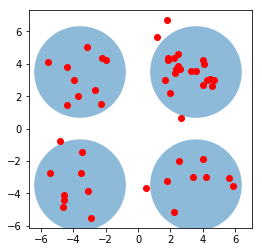

In [9]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle

STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [10]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [ ]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [ ]:
KLs = []
EUBOs = []
log_qs = []
ESSs = []## Dataset parameters
ELBOs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    
    enc, eubo, kl, ess, latents_dirs, Z_ret, elbo  = rws_nested(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws, num_particles_smc, mcmc_steps)
    eubo.backward()
    optimizer.step()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess)
    optimizer.zero_grad()
    time_end = time.time()
    print('epoch : %d, EUBO : %f, KL : %f (%ds)' % (epoch, eubo, kl, time_end - time_start))
    
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, KLs_r, ESSs, PATH_ENC)

In [ ]:
conjugate_post = alpha_trans_0 + pairwise(Zs_true, T).sum(0)
print('variational : ')
print(latents_dirs)
print('conjugate posterior :')
print(conjugate_post)
# plot_dirs(latents_dirs, alpha_trans_0, Zs_true, T, K, vmax=11)
fig3 = plt.figure(figsize=(12,6))
ax1 = fig3.add_subplot(1, 2, 1)
infer_plot = ax1.imshow(latents_dirs.data.numpy(), cmap='viridis', vmin=0, vmax=15)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('variational')
ax2 = fig3.add_subplot(1, 2, 2)
true_plot = ax2.imshow(conjugate_post.data.numpy(), cmap='viridis', vmin=0, vmax=15)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('conjugate posterior')
cax = fig3.add_axes([1.0, 0.15, 0.03, 0.7])
fig3.colorbar(true_plot, cax=cax, orientation='vertical')
# cbaxes = fig3.add_axes([0.95, 0.32, 0.02, 0.36])
# cb = plt.colorbar(true_plot, cax = cbaxes)
fig3.savefig("%drws-%dsmc-%dmcmc-%dnoise-%ddt-%dTmin.png" % (num_particles_rws, num_particles_smc, mcmc_steps, noise_ratio, dt, T_min))

In [ ]:
plt.plot(KLs)
plt.savefig('mcmc_30rws_5mcmc_10noise')

In [ ]:
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)